In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

wine = fetch_openml(name="wine-quality-red", as_frame=True)
data = wine.frame
data.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,class
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Epoch 0, Loss: 62.384663
Epoch 10, Loss: 15.566742
Epoch 20, Loss: 9.807653
Epoch 30, Loss: 7.083546
Epoch 40, Loss: 5.483430
Epoch 50, Loss: 4.434357
Epoch 60, Loss: 3.703139
Epoch 70, Loss: 3.165367
Epoch 80, Loss: 2.752284
Epoch 90, Loss: 2.425739


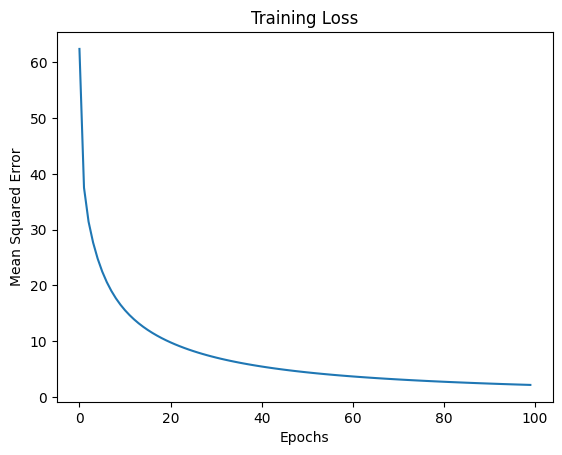

In [ ]:
X = data.drop(columns=["class"])
y = data["class"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

input_size = X_train.shape[1]
hidden_size = 8
output_size = 1
learning_rate = 0.01
epochs = 100

W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size)
b2 = np.zeros((1, output_size))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

errors = []

for epoch in range(epochs):
    hidden_layer_input = np.dot(X_train, W1) + b1
    hidden_layer_output = relu(hidden_layer_input)
    output_layer_input = np.dot(hidden_layer_output, W2) + b2
    output = output_layer_input

    error = y_train.values.reshape(-1, 1) - output
    loss = np.mean(error**2)
    errors.append(loss)

    d_output = -2 * error / len(y_train)
    d_hidden = np.dot(d_output, W2.T) * relu_derivative(hidden_layer_output)

    W2 -= learning_rate * np.dot(hidden_layer_output.T, d_output)
    b2 -= learning_rate * np.sum(d_output, axis=0, keepdims=True)
    W1 -= learning_rate * np.dot(X_train.T, d_hidden)
    b1 -= learning_rate * np.sum(d_hidden, axis=0, keepdims=True)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.6f}')

plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss')
plt.show()

*  Почему обратное распространение эффективно для глубоких сетей? Обратное распространение эффективно, так как вычисляет градиенты всех слоев через цепное правило, ускоряя обучение. Оно также снижает вычислительные затраты, позволяя обновлять параметры сети за один проход.  
*  Какие ограничения имеет данный алгоритм (проблемы с
градиентами и их затуханием)? Алгоритм страдает от затухания и взрыва градиентов, что усложняет обучение глубоких сетей. Также его эффективность зависит от инициализации весов и выбора функции активации.

#Часть 2: Методы оптимизации и эксперименты

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import tqdm

In [ ]:
def load_data(batch_size):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
def train_model(train_loader, test_loader, opt_fn, criterion, lr, device, epochs=5):
    model = NeuralNetwork().to(device)
    optimizer = opt_fn(model.parameters(), lr)

    train_loss, test_loss, test_accuracy = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss.append(total_loss / len(train_loader))

        model.eval()
        correct, total, test_total_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm.tqdm(test_loader, desc="Evaluating"):
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                test_total_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss.append(test_total_loss / len(test_loader))
        test_accuracy.append(correct / total)

    return train_loss, test_loss, test_accuracy

Сделал обучение на 5 эпох, т.к. ооооочень долго обучать 36 моделей на 10-ти эпохах

In [ ]:
batch_sizes = [16, 32, 64]
learning_rates = [0.01, 0.1, 0.001]
optimizers = {
    "SGD": lambda params, lr: optim.SGD(params, lr=lr),
    "Adam": lambda params, lr: optim.Adam(params, lr=lr),
    "RMSprop": lambda params, lr: optim.RMSprop(params, lr=lr),
    "Momentum": lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9)
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

results = {}
for batch_size in batch_sizes:
    train_loader, test_loader = load_data(batch_size)
    for name, opt_fn in optimizers.items():
        for lr in learning_rates:
            train_loss, test_loss, test_accuracy = train_model(train_loader, test_loader, opt_fn, criterion, lr, device)
            results[(name, batch_size, lr)] = (train_loss, test_loss, test_accuracy)

Evaluating: 100%|██████████| 157/157 [00:01<00:00, 89.94it/s]


In [ ]:
results

{('SGD',
  16,
  0.01): ([0.5326923093462984,
   0.2511261773486932,
   0.1868627777160456,
   0.1485865233703206,
   0.12243177750523512], [0.28109551907777786,
   0.22332589737549424,
   0.17009036624357105,
   0.15121555272676052,
   0.11742939003985375], [0.9193, 0.9363, 0.9497, 0.9558, 0.9642]),
 ('SGD',
  16,
  0.1): ([0.362347467993324,
   0.17193598918108424,
   0.13610555117075565,
   0.11347063754349995,
   0.10032353274615016], [0.16075321508143098,
   0.17283040949041023,
   0.13707665403935826,
   0.10997638152858417,
   0.1481487053158635], [0.9512, 0.9439, 0.9598, 0.9667, 0.956]),
 ('SGD',
  16,
  0.001): ([1.7189455319563547,
   0.645849289504687,
   0.448777222186327,
   0.38869879297415416,
   0.35625260358552135], [0.9108159989356994,
   0.4844503346681595,
   0.3962051703214645,
   0.3538809709995985,
   0.3345084448128939], [0.7826, 0.8671, 0.8879, 0.8981, 0.9031]),
 ('Adam',
  16,
  0.01): ([0.47998855087539805,
   0.3727363910462397,
   0.35703660726950814,
   0.

In [ ]:
for name, batch_size, lr in results.keys():
    print(f"Optimizer: {name}, Batch Size: {batch_size}, LR: {lr} Train loss: {results[(name, batch_size, lr)][0][-1]:.2f}, Test loss: {results[(name, batch_size, lr)][1][-1]:.2f} Accuracy: {results[(name, batch_size, lr)][2][-1]:.4f}")

Optimizer: SGD, Batch Size: 16, LR: 0.01 Train loss: 0.12, Test loss: 0.12 Accuracy: 0.9642
Optimizer: SGD, Batch Size: 16, LR: 0.1 Train loss: 0.10, Test loss: 0.15 Accuracy: 0.9560
Optimizer: SGD, Batch Size: 16, LR: 0.001 Train loss: 0.36, Test loss: 0.33 Accuracy: 0.9031
Optimizer: Adam, Batch Size: 16, LR: 0.01 Train loss: 0.33, Test loss: 0.27 Accuracy: 0.9325
Optimizer: Adam, Batch Size: 16, LR: 0.1 Train loss: 2.32, Test loss: 2.31 Accuracy: 0.1032
Optimizer: Adam, Batch Size: 16, LR: 0.001 Train loss: 0.09, Test loss: 0.12 Accuracy: 0.9635
Optimizer: RMSprop, Batch Size: 16, LR: 0.01 Train loss: 0.45, Test loss: 0.46 Accuracy: 0.8620
Optimizer: RMSprop, Batch Size: 16, LR: 0.1 Train loss: 2.32, Test loss: 2.32 Accuracy: 0.0980
Optimizer: RMSprop, Batch Size: 16, LR: 0.001 Train loss: 0.10, Test loss: 0.10 Accuracy: 0.9701
Optimizer: Momentum, Batch Size: 16, LR: 0.01 Train loss: 0.11, Test loss: 0.13 Accuracy: 0.9597
Optimizer: Momentum, Batch Size: 16, LR: 0.1 Train loss: 2.3

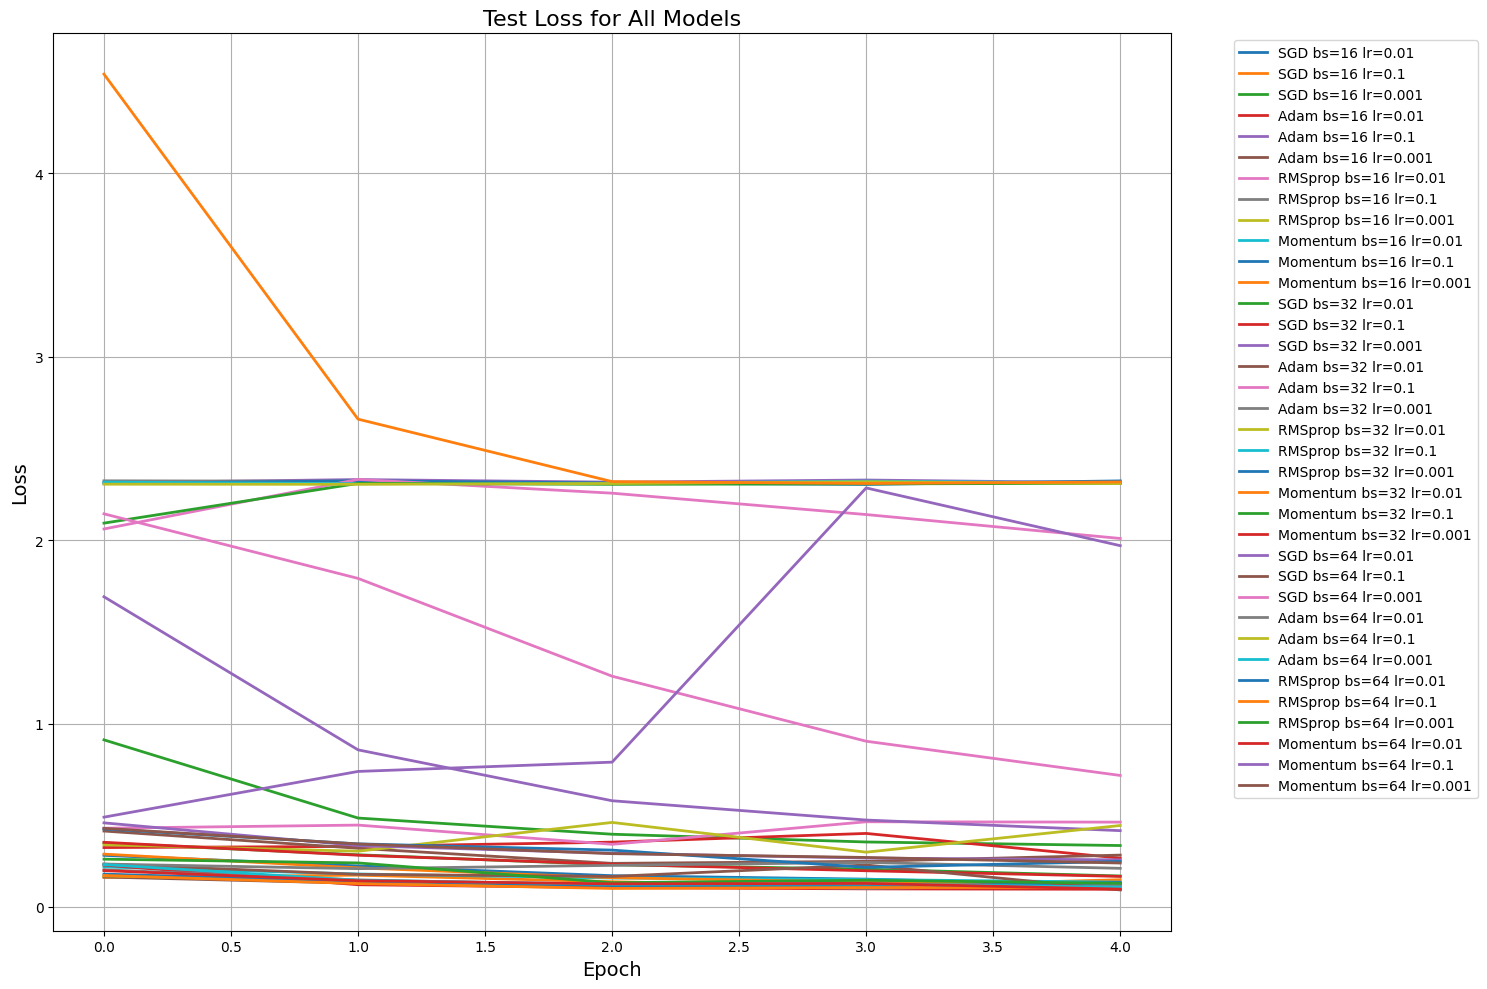

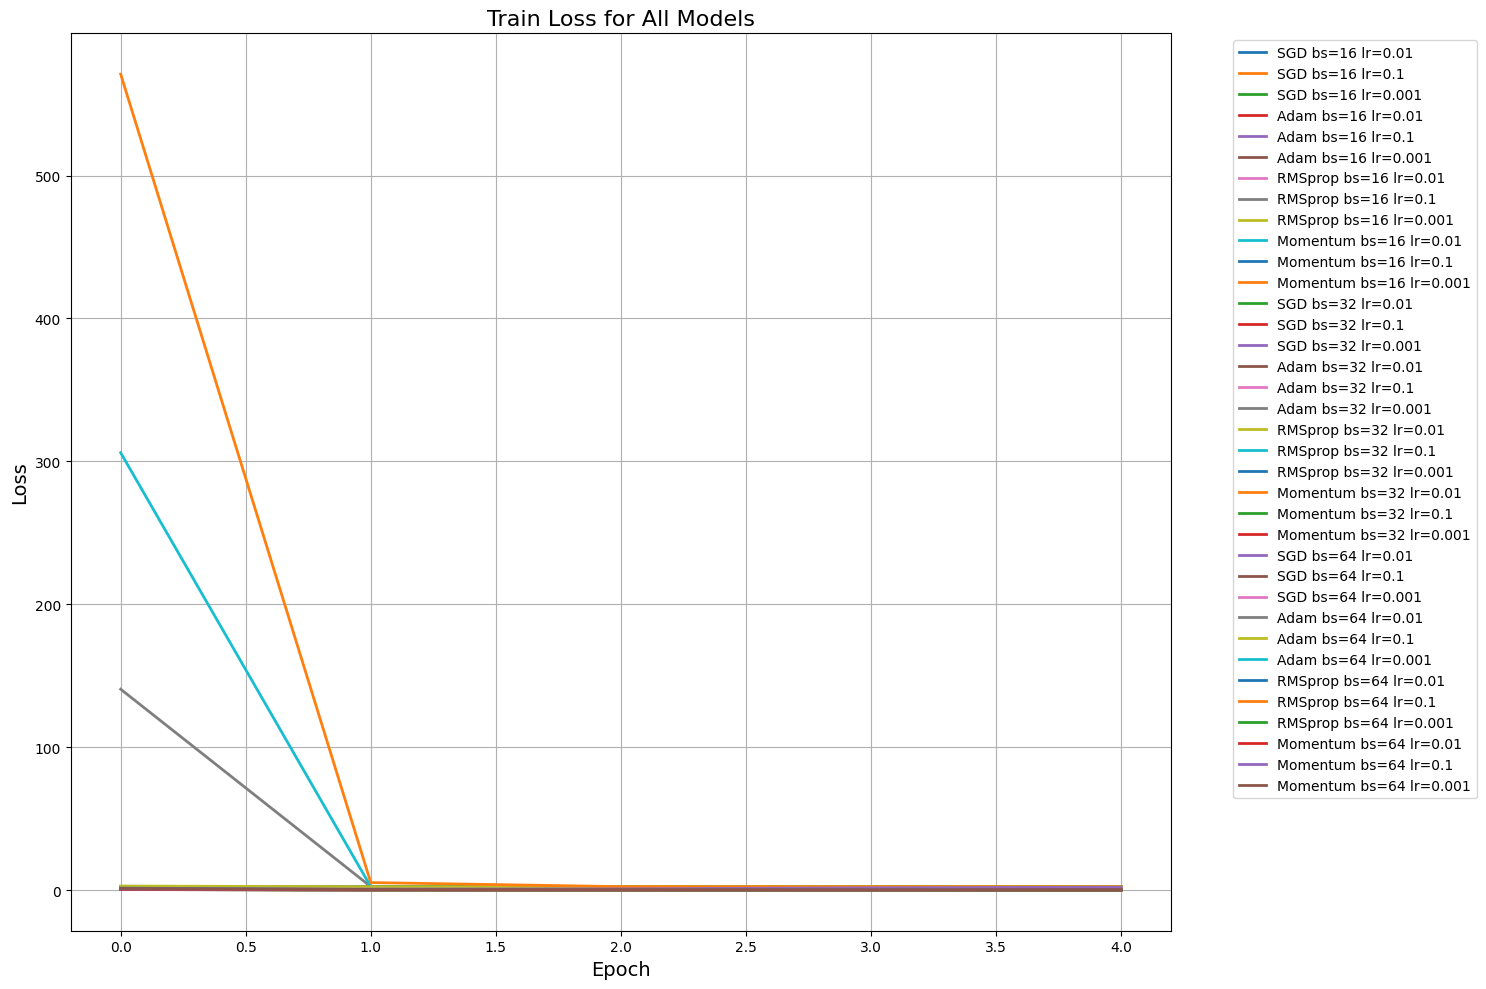

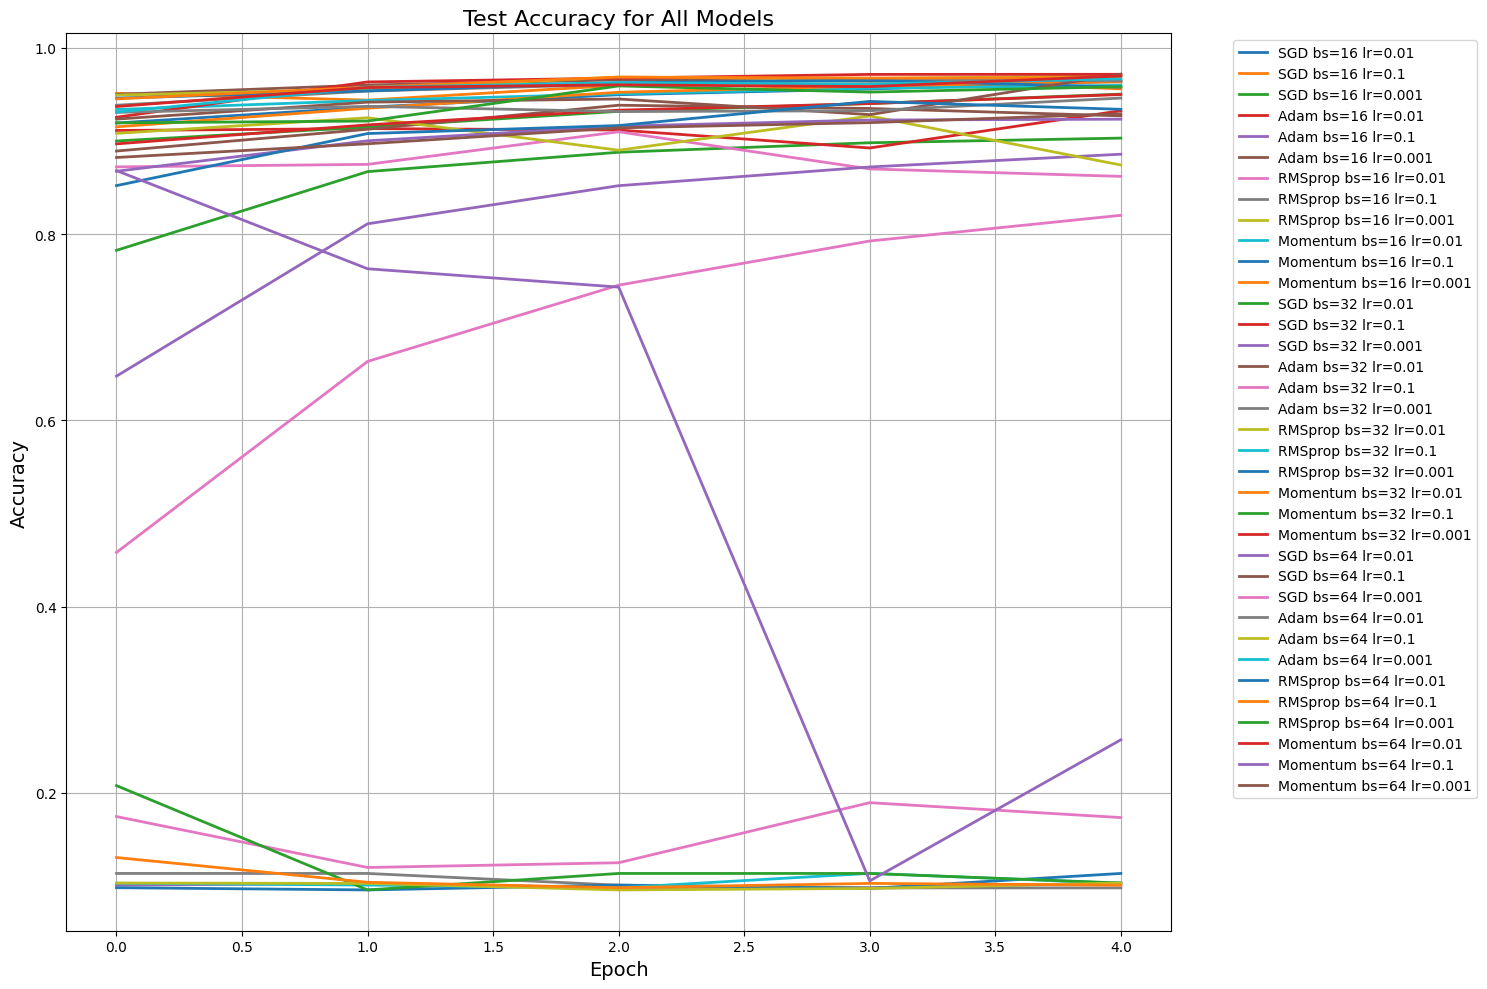

In [ ]:
legend_labels = [f"{name} bs={bs} lr={lr}" for name, bs, lr in results.keys()]

#test_loss
plt.figure(figsize=(15, 10))
for i, ((name, batch_size, lr), (train_loss, test_loss, test_accuracy)) in enumerate(results.items()):
    plt.plot(test_loss, label=legend_labels[i], linewidth=2)

plt.title('Test Loss for All Models', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#train_loss
plt.figure(figsize=(15, 10))
for i, ((name, batch_size, lr), (train_loss, test_loss, test_accuracy)) in enumerate(results.items()):
    plt.plot(train_loss, label=legend_labels[i], linewidth=2)

plt.title('Train Loss for All Models', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#test_accuracy
plt.figure(figsize=(15, 10))
for i, ((name, batch_size, lr), (train_loss, test_loss, test_accuracy)) in enumerate(results.items()):
    plt.plot(test_accuracy, label=legend_labels[i], linewidth=2)

plt.title('Test Accuracy for All Models', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
optimizer_avg_accuracy = {}

for (name, batch_size, lr), (train_loss, test_loss, test_accuracy) in results.items():
    if lr == 0.1:
        continue

    if name not in optimizer_avg_accuracy:
        optimizer_avg_accuracy[name] = []

    final_accuracy = test_accuracy[-1]
    optimizer_avg_accuracy[name].append(final_accuracy)

for optimizer in optimizer_avg_accuracy:
    avg_accuracy = np.mean(optimizer_avg_accuracy[optimizer])
    print(f"{optimizer}: Средний accuracy = {avg_accuracy:.4f}")

SGD: Средний accuracy = 0.9078
Adam: Средний accuracy = 0.9501
RMSprop: Средний accuracy = 0.9261
Momentum: Средний accuracy = 0.9567


#Часть 3: Анализ и защита

В ходе экспериментов было установлено, что адаптивные оптимизаторы Adam и Momentum демонстрируют наиболее быструю сходимость благодаря использованию адаптивных коэффициентов обучения. При этом классический SGD, хотя и требует больше времени на обучение, в оптимальной конфигурации (batch size=32, learning rate=0.1) показал наилучший результат с точностью 97.16%. Наибольшая эффективность была достигнута при следующих комбинациях параметров: для Adam - batch size 16 с learning rate 0.001, для Momentum - batch size 16 с learning rate 0.01, а для SGD - batch size 32 с learning rate 0.01.

Основные выводы исследования свидетельствуют, что адаптивные методы оптимизации (Adam, Momentum) являются наиболее надежным выбором для глубоких нейронных сетей, обеспечивая баланс между скоростью обучения и качеством результатов. При этом традиционный SGD, несмотря на необходимость тщательного подбора параметров, в оптимальной конфигурации может превзойти адаптивные методы по конечной точности. Критически важным фактором оказался выбор размера батча (оптимальный диапазон 16-32) и learning rate (наиболее стабильные результаты при значениях 0.001-0.01). Практические рекомендации предполагают использование Adam или Momentum как стартовых оптимизаторов с последующей возможной тонкой настройкой через SGD для достижения максимальной производительности модели.